In [ ]:
library(tidyverse)
library(ggridges)
library(ggdark)
library(RColorBrewer)
library(wesanderson)
library(bbplot)
library(rcartocolor)
library(highcharter)
library(hms)
library(gridExtra)

options(repr.plot.width=9, repr.plot.height=5.5)

# Australian Road Deaths
## Exploratory Data Analysis
### Johnny Barrett
___

### Introduction

This analysis will explore Australian road fatatilites from 1989 - 2020, utilising data sets provided by the Australian Government's Australian Road Deaths Database (ARDD). 

There are two datasets, one where each observation is an individual fatality, and one where each observation is a crash involving one or more fatalities. For the purposes of this analysis, we will focus on the 'Crashes' data set, and draw on observations from the 'Fatalities' data set if required.

In this analysis, we aim to gain a basic understanding of our data and uncover any patterns that occur, to hopefully give us insight into where, when and why fatal crashes occur on Australian roads. These patterns we uncover could help us determine the best strategies and frameworks to put in place to reduce road fatalities in the future.

___
### Import

Accompaning these datasets is a dictionary, which provides helpful information on the variables listed within the datasets.
Importantly, the dictionary states:   

- "A value of ‘-9’ is used for a missing/unknown value."  
- "The link between [the two datasets] is made by the Crash ID field."

After a quick initial visual scan of the data online, before import into R, we can see that a number of columns contain some empty cells (rather than using '-9' as symbol for missing/unknown values). Upon import, we will set both empty cells and cells containing '-9' to NA.

In [ ]:
crashes <- read_csv("https://data.gov.au/data/dataset/5b530fb8-526e-4fbf-b0f6-aa24e84e4277/resource/d54f7465-74b8-4fff-8653-37e724d0ebbb/download/bitre_ardd_fatal_crashes.csv", na = c("-9", ""))

### Questions relating to the data

There are two initial questions we can use to help guide us through our analysis:  

1. WHEN: Are there a disproportionate amount of fatal crashes occuring in a particular time period?  
2. WHERE: Are there a disproportionate amount of fatal crashes occuring in a particular location?  

But first, let's take a look at the overall structure of our dataset:

In [4]:
summary(crashes)

    Crash ID           State               Month            Year     
 Min.   :19891001   Length:45876       Min.   : 1.00   Min.   :1989  
 1st Qu.:19947015   Class :character   1st Qu.: 4.00   1st Qu.:1994  
 Median :20016014   Mode  :character   Median : 7.00   Median :2001  
 Mean   :20025239                      Mean   : 6.57   Mean   :2002  
 3rd Qu.:20096013                      3rd Qu.:10.00   3rd Qu.:2009  
 Max.   :20207001                      Max.   :12.00   Max.   :2020  
                                                                     
   Dayweek              Time           Crash Type        Number Fatalities
 Length:45876       Length:45876      Length:45876       Min.   : 1.000   
 Class :character   Class1:hms        Class :character   1st Qu.: 1.000   
 Mode  :character   Class2:difftime   Mode  :character   Median : 1.000   
                    Mode  :numeric                       Mean   : 1.112   
                                                         3rd Qu.:

We can see that some the variable names are long and ambiguous. For ease of use, let's do some renaming of some of the longer and counter-intuitive variable names:

In [5]:
crashes <- rename(crashes, Bus=`Bus \nInvolvement`, `Truck Heavy`=`Heavy Rigid Truck Involvement`,
                  `Truck Atcl`=`Articulated Truck Involvement`, Remoteness=`National Remoteness Areas`,
                  `ABS Region`=`SA4 Name 2016`, `Govt Area`=`National LGA Name 2017`)

All of our missing data points in our data set are for categorical variables, except for `Speed Limit`, which is numeric.
For all our categorical variables, we can introduce a new category "missing", and set all NA values to this category.
We can also see from the summary that the categorical variables are all currently represented as `class: character`. We will transform the data so that each categorical variable becomes `class: factor`:

In [6]:
crashes <- crashes %>%
  mutate_if(is.character, ~replace_na(., "missing")) %>% 
  mutate_if(is.character, as.factor)

To check this type conversion was successful:

In [7]:
head(crashes)

Crash ID,State,Month,Year,Dayweek,Time,Crash Type,Number Fatalities,Bus,Truck Heavy,Truck Atcl,Speed Limit,Remoteness,ABS Region,Govt Area,National Road Type,Christmas Period,Easter Period,Day of week,Time of Day
<dbl>,<fct>,<dbl>,<dbl>,<fct>,<time>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
20202014,Vic,1,2020,Tuesday,22:00:00,Pedestrian,1,missing,missing,missing,NA,Inner Regional Australia,Latrobe - Gippsland,Bass Coast (S),Arterial Road,No,No,Weekday,Night
20205007,WA,1,2020,Saturday,14:40:00,Multiple,2,No,No,No,110,missing,missing,missing,missing,No,No,Weekend,Day
20205002,WA,1,2020,Wednesday,10:00:00,Single,1,No,No,No,110,missing,missing,missing,missing,No,No,Weekday,Day
20205005,WA,1,2020,Sunday,15:50:00,Single,2,No,No,No,110,missing,missing,missing,missing,No,No,Weekend,Day
20201019,NSW,1,2020,Saturday,14:50:00,Multiple,1,No,No,No,70,Major Cities of Australia,Central Coast,Central Coast,Arterial Road,No,No,Weekend,Day
20206001,Tas,1,2020,Saturday,12:30:00,Pedestrian,1,Yes,No,No,50,Outer Regional Australia,West and North West,Burnie (C),Local Road,No,No,Weekend,Day


___
### Investigating missing values

An initial overview of the number of missing values per column will help us handle them:

In [8]:
colSums(crashes == "missing" | is.na(crashes))

Crash ID              State              Month               Year 
                 0                  0                  0                  0 
           Dayweek               Time         Crash Type  Number Fatalities 
                 0                 36                  0                  0 
               Bus        Truck Heavy         Truck Atcl        Speed Limit 
                22              18178                 20               1241 
        Remoteness         ABS Region          Govt Area National Road Type 
             40856              40842              40841              40852 
  Christmas Period      Easter Period        Day of week        Time of Day 
                 0                  0                  0                  0

We can see that many values for `Remoteness`, `ABS Region`, `Govt Area` and `National Road Type` are missing, and the counts of missing values are very similar.  
To check if these missing values are correlated:

In [9]:
num.remote.na <- dim(crashes %>% filter(Remoteness=="missing"))[1]
all.four.na <- crashes %>% 
    filter(Remoteness=="missing", `ABS Region`=="missing",
          `Govt Area`=="missing", `National Road Type`=="missing")

paste0("Correlation of missing values: ", round((dim(all.four.na)[1] / num.remote.na) * 100, 2), "%")

[1] "Correlation of missing values: 99.93%"

We can see that 99.94% of the observations where a value for `Remoteness` is missing, values for `ABS Region`, `Govt Area` and `National Road Type` are also missing.

Let's look at the spread of NA values for Remoteness per year:

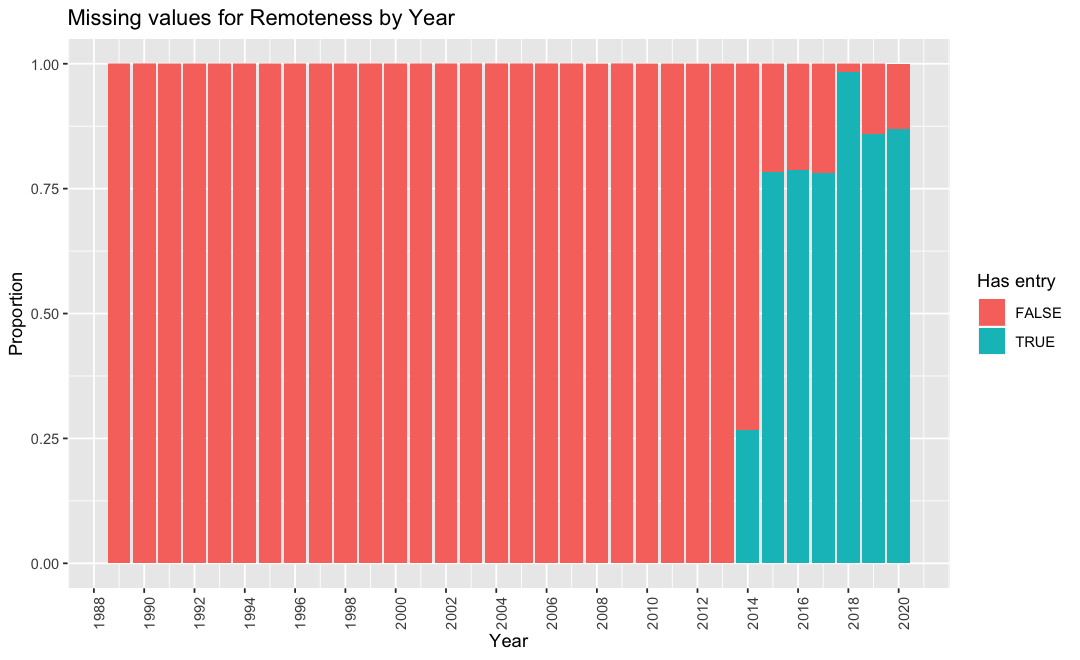

In [10]:
ggplot(crashes, aes(x = Year, y = length(Remoteness))) +
    geom_bar(aes(fill = !crashes$Remoteness=="missing"), stat = "identity", position = "fill") +
    labs(title="Missing values for Remoteness by Year", y="Proportion", fill="Has entry") +
    theme(axis.text.x = element_text(angle = 90)) +
    scale_x_continuous(breaks = pretty(crashes$Year, n = 22))

We can see in this barplot that the variable Remoteness was only recorded from 2014 onwards. As we saw before, missing values for `Remoteness` have a strong correlation with missing values for `ABS Region`, `Govt Area` and `National Road Type`. To use any data in these variables, we should only consider data from 2014 onwards.

___
### Question 1: WHEN?

The first question we will investigate is whether or not there are any relationships between time and the number of fatal crashes.  

First, let's look at the number of fatal crashes per year:

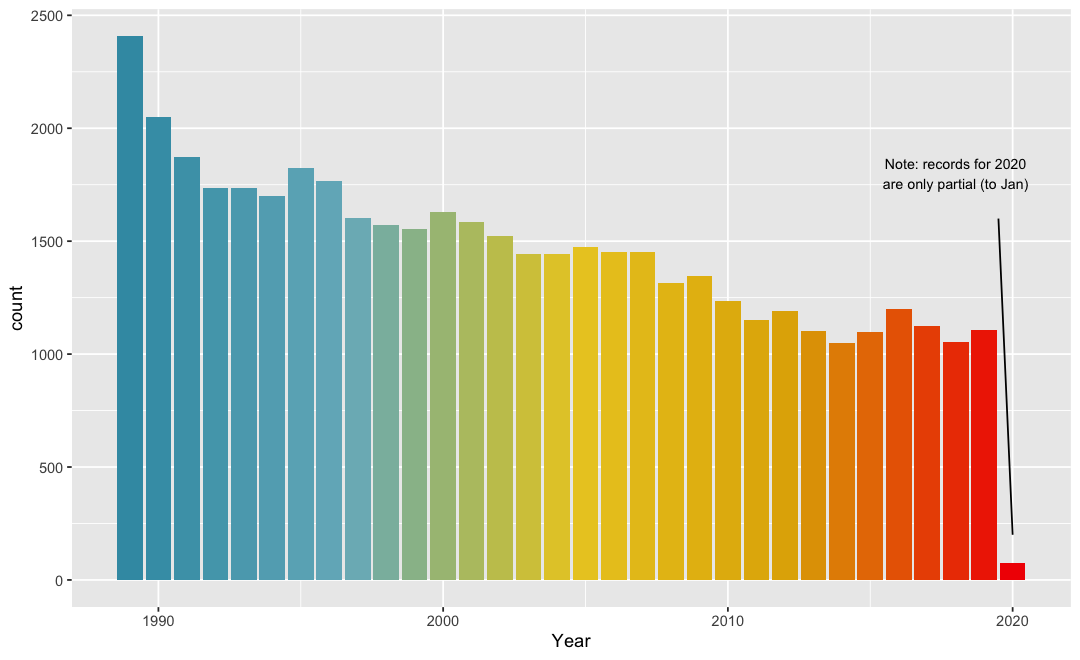

In [11]:
ggplot(crashes, aes(x = Year)) +
    geom_bar(
        aes(fill = factor(Year)),
        show.legend = F) +
    scale_fill_manual(values=wes_palette("Zissou1", 32, type="continuous")) + 
    annotate("text", x=2018, y=1800, label="Note: records for 2020\nare only partial (to Jan)", size=3) +
    annotate("segment", x=2020, xend=2019.5, y=200, yend=1600)

Here we see a positive result: that there is a negative trend between number of crashes and Year, meaning that, in general, there are less fatal crashes each Year.

Let's now look at the number of fatal crashes per month, to see if there are any months that have a higher number of crashes. We saw in the overview earlier that months were represented in their numerical form, however it may be more meaningful to view these as their actual names. We will add a new ordered factor column with the month names:

In [12]:
month.names <- factor(month.name[crashes$Month], levels = month.name[1:12])
crashes <- crashes %>%
    add_column(`Month Name` = month.names, .after = "Month")

To accurately view the distribution of fatal crashes across months, we will remove records for 2020, as they are only partial (only January):

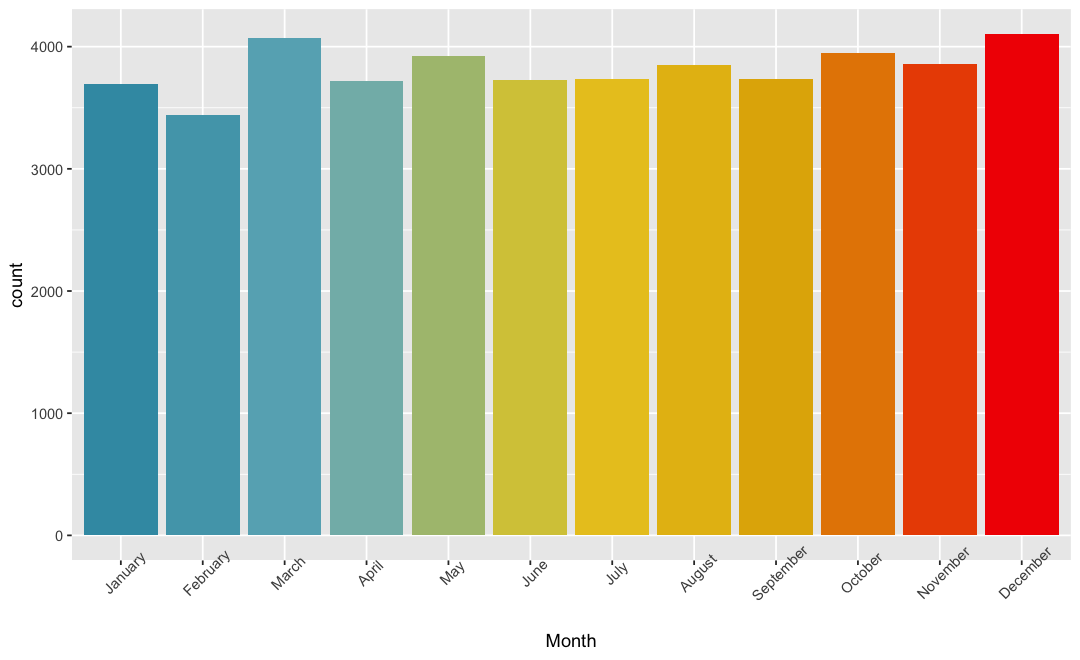

In [13]:
ggplot(subset(crashes, Year < 2020)) +
    geom_bar(aes(x = `Month Name`, fill = `Month Name`)) +
    theme(axis.text.x = element_text(angle = 45), plot.title = element_text(hjust = 0.5)) +
    scale_fill_manual(values=wes_palette("Zissou1", 12, type="continuous")) +
    theme(legend.position = "none") + xlab("Month")

Interestingly, crashes seem to have a relatively uniform distribution across months, with a slight increase in March and December, and a slight decrease in February.

Now let's take a look at the distribution of fatal crashes across days of the week. But first, as days of the week are inheritently ordinal, we will transform our factor column `Dayweek` into an ordered factor, beginning on Monday and finishing on Sunday:

Inverted geom defaults of fill and color/colour.
To change them back, use invert_geom_defaults().



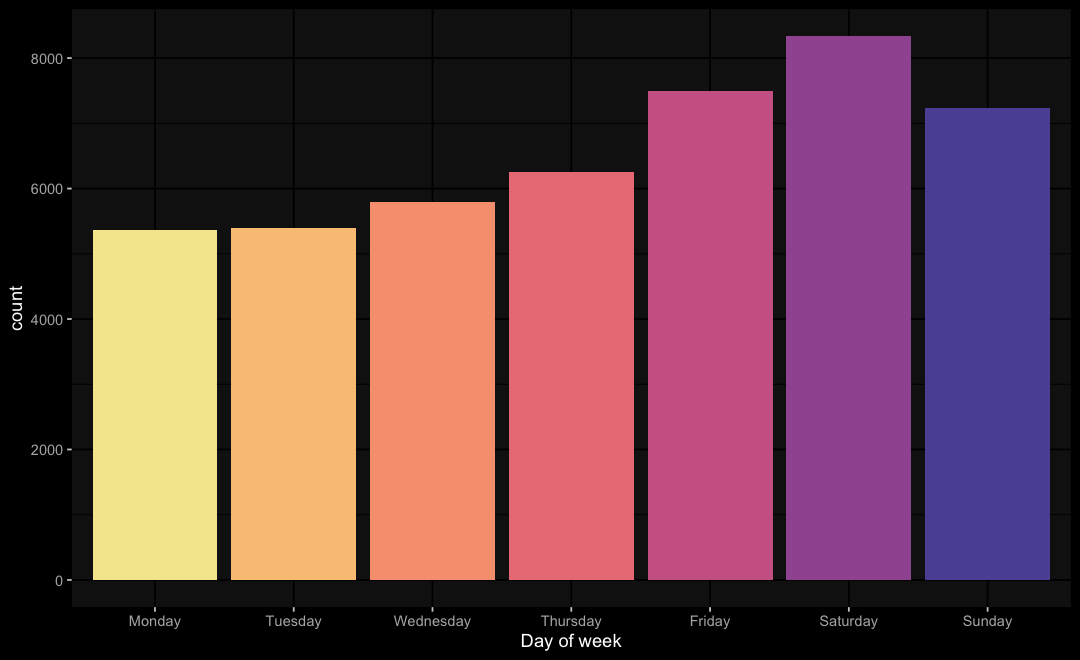

In [14]:
crashes$Dayweek <- ordered(crashes$Dayweek,
                        levels = c("Monday", "Tuesday",
                                   "Wednesday", "Thursday",
                                   "Friday", "Saturday", "Sunday"))

ggplot(crashes, aes(x = Dayweek, fill = Dayweek)) +
    geom_bar(show.legend = F) +
    labs(x = "Day of week") + 
    scale_fill_carto_d(palette = "Sunset") +
    dark_mode()

This graph shows that there is a positive trend in the number of crashes throughout the week, peaking on Saturday.

Let's investigate this result on a smaller scale, by looking at the distribution of crashes across each day. A ridge plot allows us to do this:

Picking joint bandwidth of 3510



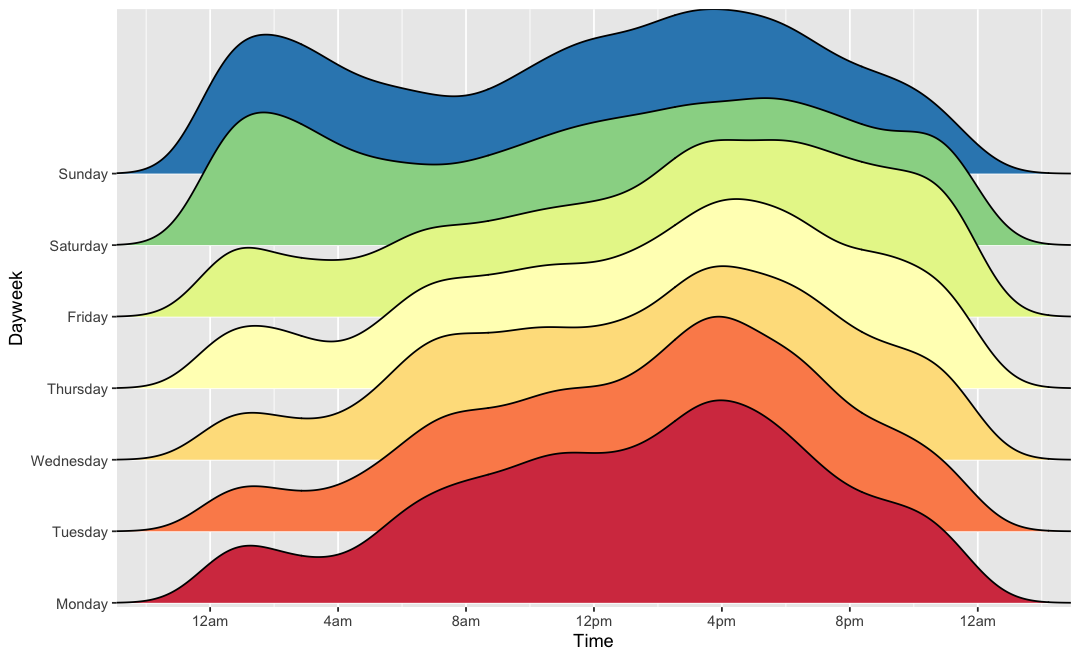

In [15]:
ggplot(crashes, aes(x = Time, y = Dayweek, fill = Dayweek)) +
  geom_density_ridges(scale = 3, colour = "black") + theme_ridges() +
  scale_y_discrete(expand = c(0.01, 0)) + 
  scale_x_continuous(breaks = seq(0, 86400, length.out = 7),  # 24hrs represented in seconds, divided into 4hr sections
                     labels = c("12am", "4am", "8am", "12pm",
                                "4pm", "8pm", "12am"),
                     expand = c(0, 0)) +
  scale_fill_brewer(palette = "Spectral") + 
  theme_gray() + theme(legend.position = "none")

This ridge plot shows that for Monday through Thursday, the distribution of the time of crashes is very similar: a unimodal distribution with a steady increase in crashes from the early morning, peaking at roughly 4pm. The distribution of crashes on Friday - Sunday are somewhat different however. At first glance, it seems the distributions on Saturday and Sunday could be bimodal, with peaks at roughly 1am and 4pm, however it is possible this observation is simply a biproduct of the way we have displayed the data. For example, the apparent 'peak' on Saturday morning could just be a continuation from Friday evening. As time is inheritently continuous, it may be more appropriate to visualise the distribution of the time of crashes for the entire week (Monday - Sunday):  

To do this, we will first need to do some data transformation:

In [16]:
# Creating a continuous time scale from 1.000 - 7.999
crashes <- crashes %>% 
  mutate(`Week Time` = as.integer(crashes$Dayweek) +  # will return 1-7
           (as.double(crashes$Time)/(24*60*60)))  # number of seconds from midnight / number of seconds in 24hrs

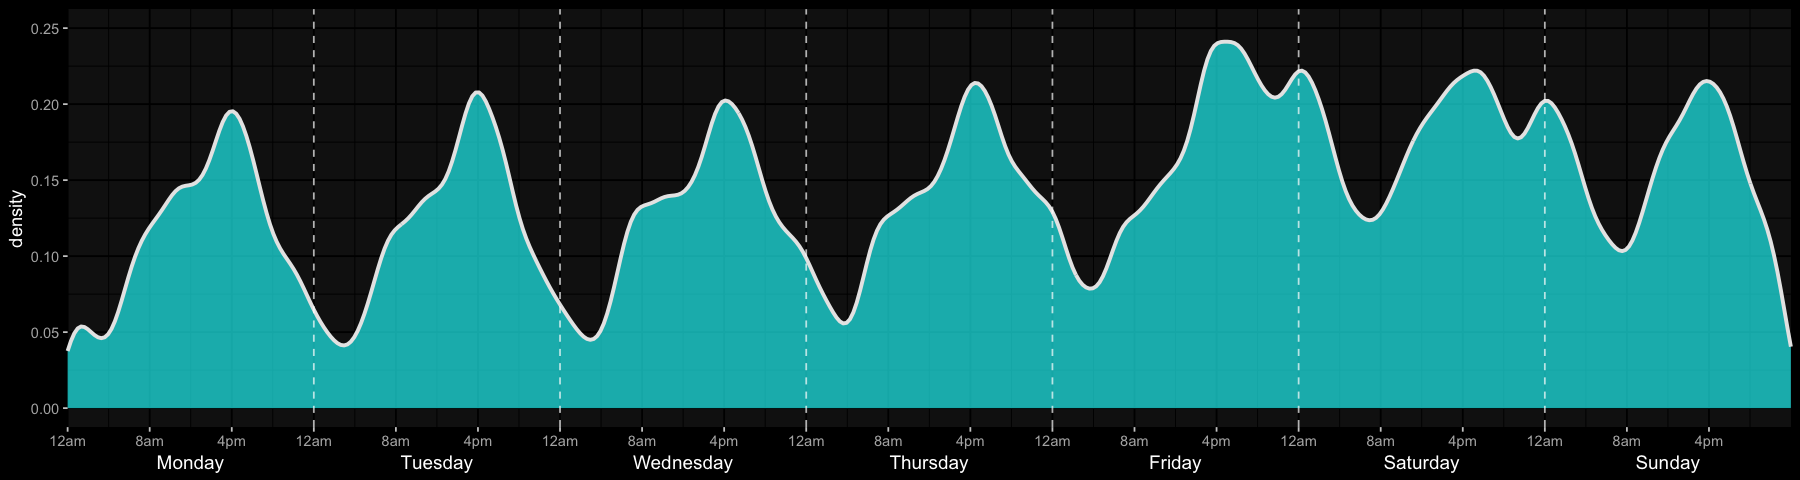

In [17]:
options(repr.plot.width=15, repr.plot.height=4)

ggplot(crashes, aes(x=`Week Time`)) +
  geom_density(fill="cyan", alpha=0.65, bw=0.045, colour=NA) +
  geom_line(stat="density", bw=0.045, size=1.1, color="#E7E7E7") +
  scale_x_continuous(breaks = seq(1, 8, length.out = 22),
                     labels = c(rep(c("12am", "8am", "4pm"), 7), "12am"),
                     expand = c(0,0)) + 
  scale_y_continuous(expand=c(0.05, 0)) +
  labs(x="") +
  geom_vline(xintercept = 2:7, linetype="dashed", alpha=0.7) +
  annotate("text", x = 0.5 + 1 * (1:7), y=-.035, label = sort(unique(crashes$Dayweek)), size=4) +
  coord_cartesian(ylim=c(0, 0.25), clip="off") + dark_mode()

Here we obtain a more accurate representation of the distribution of the time of crashes throughout the week, particularly for Friday - Sunday. We can now see the peak time for crashes throughout the week is on Friday at roughly 4pm, and that the on both Friday and Saturday evening there is another peak at roughly 12am.

The key question these two plots raise, that we can investigate later, is: Why is the late afternoon the peak time for fatal crashes each day?

___
### Question 2: WHERE?

The second question we will investigate is whether or not there are any relationships between location and the number of fatal crashes.

Firstly, we can use a choropleth to see the number of fatal crashes since 1989, per state:

In [18]:
# Getting observation counts per state and adding state code column for Highcharter:
crash.per.state <- crashes %>%
  count(State) %>%
  add_column(code = c('au-ct', 'au-ns', 'au-nt',
                      'au-ql', 'au-sa', 'au-ts',
                      'au-vi', 'au-wa'))

# Creating map:
map <- hcmap(map = "countries/au/au-all", data = crash.per.state,
      joinBy = c("hc-key","code"), value = "n", name = "Fatal crashes",
      dataLabels = list(enabled = TRUE, format = '{point.name}'),
      borderColor = "#ffffff", borderWidth = 3)

In [19]:
map %>%
  hc_colorAxis(minColor="#ffe88a", maxColor='#7a0000') %>% 
  hc_title(text = "Total Number of Fatal Crashes By State")

HTML widgets cannot be represented in plain text (need html)

From this, we might assume that New South Wales has a disportionatly high amount of fatal crashes, however the data does not take into consideration the numbers of drivers/cars in each state, and the plot would likely look similar if we had simply plotted these. It will be more informative to visualise the number of crashes as a proportion of the number of registered vehicles in each state. The Australian Bureau of Statistics provides this data: https://www.abs.gov.au/ausstats/abs@.nsf/mf/9309.0

In [ ]:
ABS.vehicles <- read_csv("ABS_Motor_Vehicle_Census_2019.csv")
ABS.vehicles <- ABS.vehicles[,order(colnames(ABS.vehicles))] %>% 
  select(-Australia)  # ordering so in same order as crash.per.state df
ABS.vehicles <- ABS.vehicles[1,-9]  # taking data from 2014 and removing Year column
# Adding registered vehicle data to crash.per.state
crash.state.prop <- crash.per.state %>%
  add_column(reg.vehicles = as.numeric(as.vector(ABS.vehicles))) %>% 
  mutate(prop = n / (reg.vehicles/100000))

We are using state registered vehicle counts from 2014, so the significance of this plot depends on the assumption that the proportion of vehicle ownership in each state has not varied enough from 1989-present to affect the results significantly.

In [21]:
map2 <- hcmap(map = "countries/au/au-all", data = crash.state.prop,
      joinBy = c("hc-key","code"), value = "prop", name = "Fatal crashes",
      dataLabels = list(enabled = TRUE, format = '{point.name}'),
      borderColor = "#ffffff", borderWidth = 3,
      tooltip = list(pointFormat = '{point.name}: <b>{point.value:.2f}'))

In [22]:
map2 %>%
  hc_colorAxis(minColor="#ffe88a", maxColor='#7a0000') %>% 
  hc_title(text = "Fatal Crashes Per 100,000 Registered Vehicles, By State")

HTML widgets cannot be represented in plain text (need html)

Here we see a very different result. We can see that most states have a comparable number of fatal crashes per 100,000 vehicles, except for the Northern Territory, which has over three times the number of any other state.

This is an alarming result, which we can investigate further.

We know that the Northern Territory is very rural, with many open roads, and is the only state/territory in Australia with speed limits up to 130 km/h. Let's investigate whether the posted speed limit has any effect on fatal crashes:

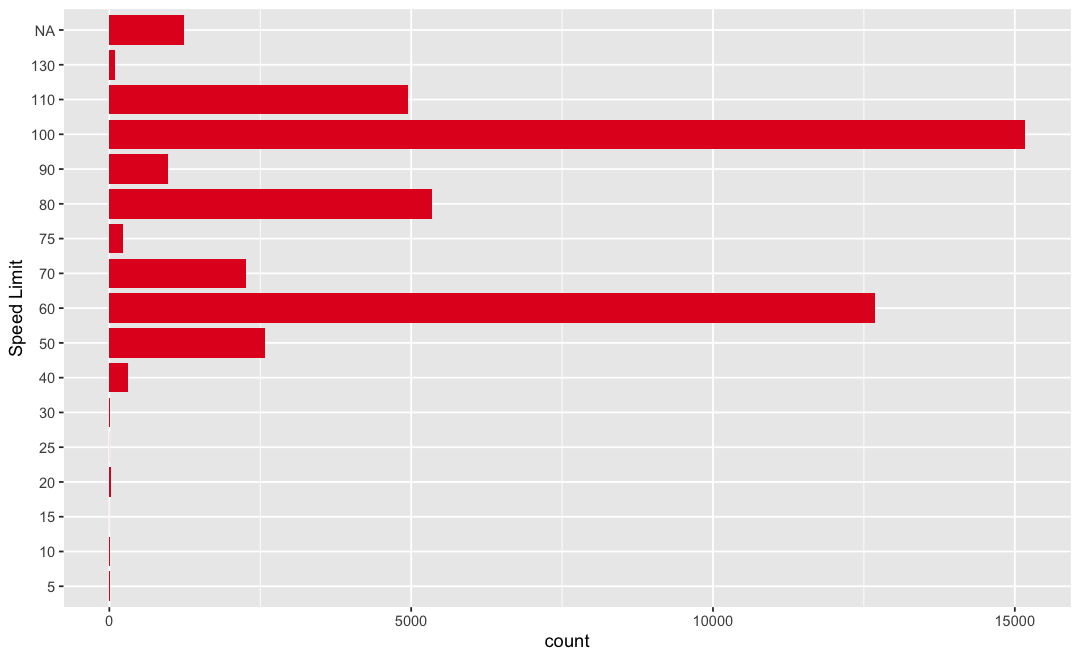

In [23]:
options(repr.plot.width=9, repr.plot.height=5.5)

crashes %>%
  ggplot(aes(x=as.factor(`Speed Limit`))) +
    geom_bar(width = 0.85, fill = "#E31A23") +
    xlab("Speed Limit") +
    coord_flip()

We can see in this plot that the variable `Speed Limit` has some anomalies that we should handle. For example, some speed limits are not a multiple of 10, some are missing and some have very small counts. We can make this data easier to interpret by creating categories for speed limits to fall into:

In [24]:
crashes <- within(crashes, {
  speedcat <- NA
  speedcat[`Speed Limit` >= 100] <- ">= 100 km/h"
  speedcat[`Speed Limit` >= 90 & `Speed Limit` < 100] <- "90 km/h"
  speedcat[`Speed Limit` >= 80 & `Speed Limit` < 90] <- "80 km/h"
  speedcat[`Speed Limit` >= 70 & `Speed Limit` < 80] <- "70 km/h"
  speedcat[`Speed Limit` >= 60 & `Speed Limit` < 70] <- "60 km/h"
  speedcat[`Speed Limit` >= 50 & `Speed Limit` < 60] <- "50 km/h"
  speedcat[`Speed Limit` >= 40 & `Speed Limit` < 50] <- "40 km/h"
  speedcat[`Speed Limit` < 40] <- "<40 km/h"
}) %>% 
  replace_na(list(speedcat= "Unknown"))

crashes$speedcat <- ordered(
  factor(crashes$speedcat),
  levels = c("Unknown", "<40 km/h", "40 km/h", "50 km/h","60 km/h",
           "70 km/h", "80 km/h", "90 km/h", ">= 100 km/h"))

It will be beneficial to create an R function that sorts categories by their value, for ordered par plots:

In [25]:
sort.by.value <- function(x){
  factor(x, levels=names(sort(table(x))))
}

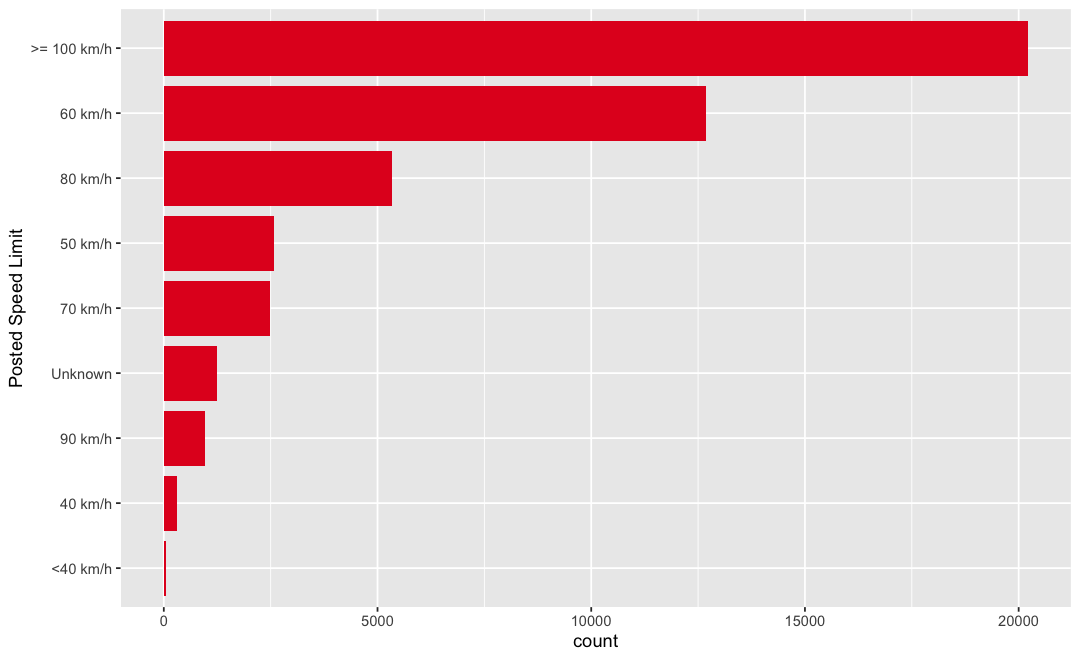

In [26]:
crashes %>% 
  within(speedcat <- sort.by.value(speedcat)) %>%
  ggplot(aes(x=as.factor(speedcat))) +
    geom_bar(width = 0.85, fill = "#E31A23") +
    xlab("Posted Speed Limit") +
    coord_flip()

We can see here that the highest number of fatal crashes occur on roads with a speed limit greater or equal to 100 km/h, roughly 45% of all crashes in our data.  
Let's look at the distribution of these speed limits per state, keeping an eye out for any significant differences in the results for the Northern Territory :

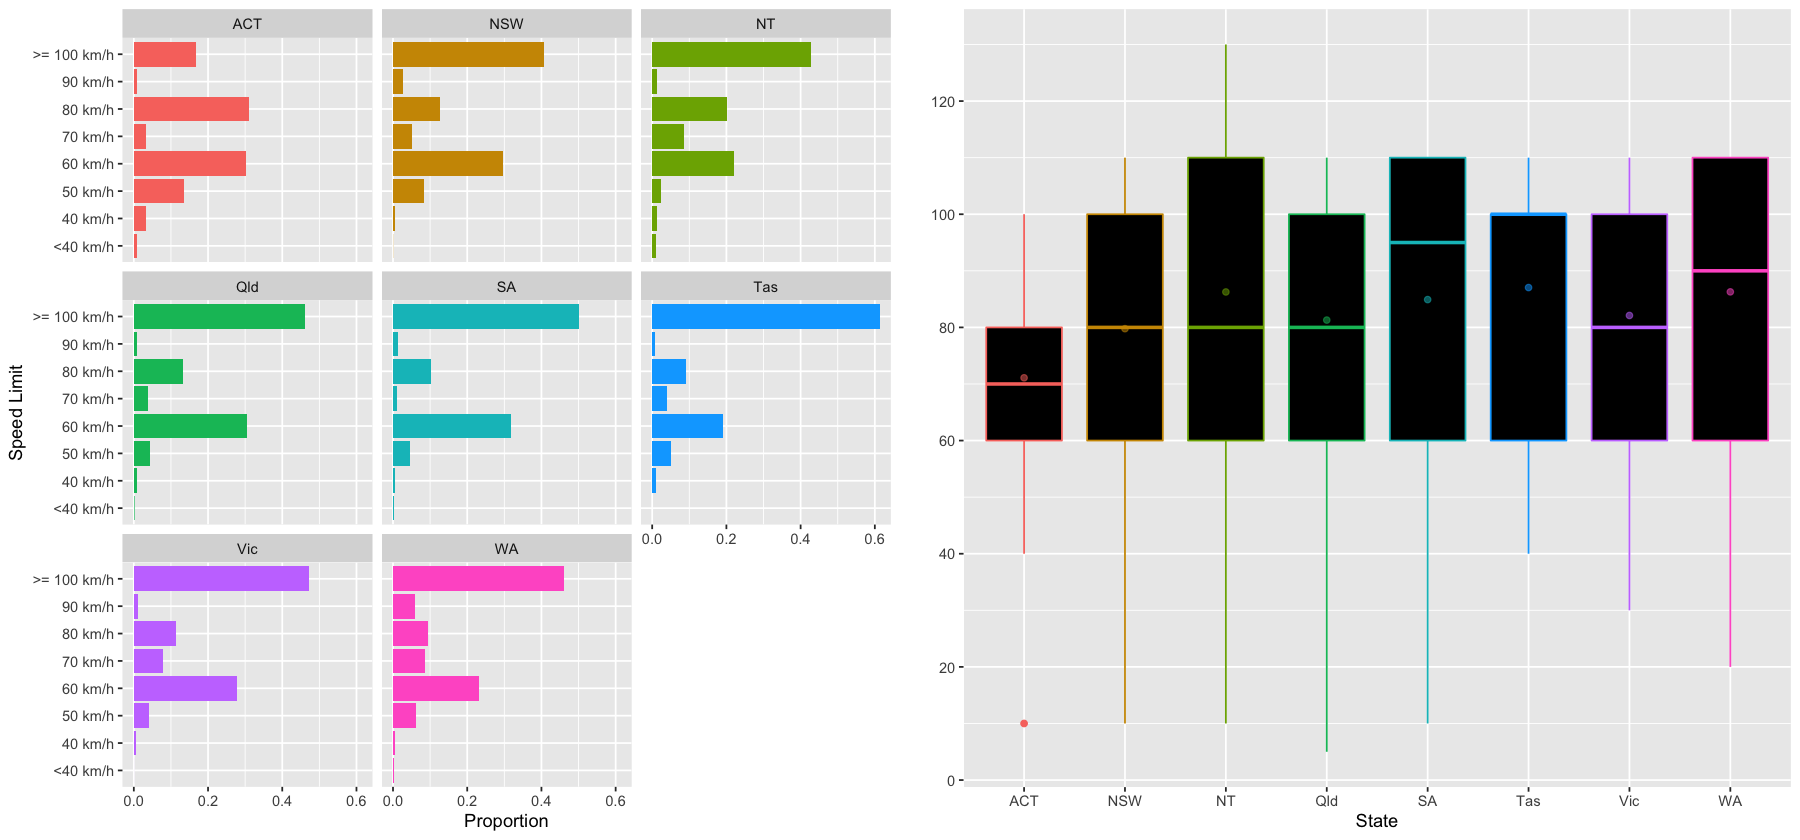

In [27]:
options(repr.plot.width=15, repr.plot.height=7)

p1 <- crashes %>% 
  filter(speedcat != "Unknown") %>% 
  ggplot(aes(x = speedcat, group = State, fill = State)) +
    geom_bar(aes(y = ..prop..), stat = "count") +
    xlab("Speed Limit") + ylab("Proportion") +
    coord_flip() +
    theme(legend.position = "none") +
    facet_wrap(~State, nrow = 3)

p2 <- ggplot(crashes, aes(x = State, y=`Speed Limit`, colour=State)) +
  geom_boxplot(na.rm = T) +
  scale_y_continuous(breaks = seq(0, 150, by = 20)) +
  stat_summary(fun.y=mean, geom="point", alpha = 0.5, na.rm = T) +
  ylab("") +
  theme(legend.position = "none")

grid.arrange(p1, p2, ncol = 2)

From the bar graph, we can see that in all states except the ACT, over 40% of fatal crashes occur on roads with a speed limit 100 km/h or greater. From this we can denote that high speeds are correlated with fatal crashes. We can also see that in all states, the second highest ranking speed limit in terms of number of fatal crashes is 60 km/h. This could simply be due to a large number of roads having this speed limit, or something else entirely (eg. most common speed for distracted driving?).

The boxplot shows us that the Northern Territory has the highest maximum speed limit, as we expected, though a similar inter-quartile range of fatal crashes across speed limits as the other states, particularly South Australia and Western Australia. Perhaps higher speed limits have some affect on the increased number of fatal crashes in the Northern Territory, proportionally, but nothing we have uncovered here suggests this significantly.

___
### Conclusion

From our exploratory data analysis, we can take a number of observations, each that raise new questions that we could explore further by use of modelling, using additional data from other sources, or simply further EDA:  

- The raw number of crashes is decreasing each year. This is a positive result, and is happening despite population growth yearly. Could this be due to increased road quality? Or perhaps safer vehicles?  

- The weekend days have a higher number of crashes than week days. Is this a factor of an increased number of drivers driving under the influence? Or an increase/decrase in number of cars on the road?  

- The peak time for fatal crashes each day is roughly 4pm. Could this be due to an increase in driver fatigue at this time? Or simply an increased number of cars on the road? 

- The Northern Territory has a disproportionate amount of fatal crashes when compared to the other states/territories. How much affect does higher speed limits have this result? Are their cultural differences here that cause this alarming result?

- Roughly 45% of all fatal crashes happen on roads with speed limits greater than 100 km/h. This result is perhaps the least suprising, but is an important statistic to recognise. What can be done about safety on these roads?



